In [ ]:
!pip install transformers torch gradio Flask pandas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/My Drive/health_fitness_dataset.csv'
model_path = '/content/drive/My Drive/health_fitness_model.pth'


In [ ]:
dataset_path = '/content/health_fitness_dataset.csv'
model_path = '/content/health_fitness_model.pth'


In [ ]:
import pandas as pd
import random

# Categories: 0 = Workout, 1 = Diet, 2 = Disease, 3 = Tips/Reminders
categories = ["Workout", "Diet", "Disease", "Tips/Reminders"]

# Expanded Hinglish queries
workout_queries = [
    "Mujhe chest ka workout suggest karo", "Kya push-ups se weight loss hota hai?",
    "Full body ka exercise plan chahiye", "Cardio karne se fat burn hota hai kya?",
    "Kya squats se legs strong hoti hain?", "Stretching kab karni chahiye?"
]

diet_queries = [
    "Mujhe weight loss ke liye diet plan chahiye", "Healthy khana ka suggestion do",
    "Diabetes ke liye diet suggest karo", "Protein intake ka ideal level kya hai?",
    "Fruits khane ka best time kya hai?", "Intermittent fasting safe hai kya?"
]

disease_queries = [
    "Fever me kya khana chahiye?", "Headache ka ilaj batao",
    "Cold and cough ka solution kya hai?", "BP control ka upay batao",
    "Kya home remedies se viral fever theek hota hai?", "Migraine ke symptoms kya hain?"
]

tips_queries = [
    "Daily water intake kitna hona chahiye?", "Healthy rehne ke tips do",
    "Stress kam karne ke upay batao", "Fitness maintain kaise karen?",
    "Daily sleep cycle kitni honi chahiye?", "Posture improve kaise karen?"
]

# Generate the dataset
data = []

# Generate 2000 samples
for _ in range(500):
    data.append((random.choice(workout_queries), 0))
    data.append((random.choice(diet_queries), 1))
    data.append((random.choice(disease_queries), 2))
    data.append((random.choice(tips_queries), 3))

# Create DataFrame
df = pd.DataFrame(data, columns=["query", "label"])

# Save as CSV
df.to_csv("health_fitness_dataset.csv", index=False)
print("Dataset generated successfully!")


Dataset generated successfully!


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("health_fitness_dataset.csv")

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenize queries
def encode_queries(query):
    return tokenizer.encode_plus(
        query,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

# Prepare tokenized data
encoded_data = [encode_queries(query) for query in df['query']]
labels = torch.tensor(df['label'].values)

input_ids = torch.cat([data['input_ids'] for data in encoded_data], dim=0)
attention_masks = torch.cat([data['attention_mask'] for data in encoded_data], dim=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Model
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Training Loop
model.train()
epochs = 3

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids, labels = batch
        optimizer.zero_grad()

        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Save the model
torch.save(model.state_dict(), "health_fitness_model.pth")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-paddin

Epoch 1, Loss: 1.231817336678505
Epoch 2, Loss: 0.21946610815823078
Epoch 3, Loss: 0.0282598184235394


In [11]:
import gradio as gr

# Load model
model.load_state_dict(torch.load("health_fitness_model.pth"))
model.eval()

# Chat history
chat_history = []

# Prediction function
def get_response(query):
    inputs = tokenizer(query, return_tensors="pt", max_length=128, truncation=True, padding="max_length")

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    categories = ["Workout", "Diet", "Disease", "Tips/Reminders"]
    advice = categories[prediction]

    chat_history.append({"query": query, "response": advice})

    return advice

# Gradio Chatbot
def chatbot(user_input, history):
    response = get_response(user_input)
    return response, history + [(user_input, response)]

# Interface
interface = gr.ChatInterface(
    chatbot,
    title="Health & Fitness Assistant",
    description="Ask Hinglish health-related queries and receive categorized responses.",
)

# Launch
interface.launch(share=True)


/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:334: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dd7127784ad1f12cc6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [12]:
import gradio as gr
import torch

# Load the model
model.load_state_dict(torch.load("health_fitness_model.pth"))
model.eval()

# Chat history
chat_history = []

# Prediction function
def get_response(query):
    """Generates the model's prediction based on the input query."""
    inputs = tokenizer(query, return_tensors="pt", max_length=128, truncation=True, padding="max_length")

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    categories = ["Workout", "Diet", "Disease", "Tips/Reminders"]
    advice = categories[prediction]

    # Append the query and response to chat history
    chat_history.append((query, advice))

    return advice

# Gradio function for chatbot interaction
def chatbot(user_input):
    """Handles the conversation with the user."""
    response = get_response(user_input)

    # Display the entire conversation history
    conversation = "\n".join([f"👤 {q}\n🤖 {r}" for q, r in chat_history])

    return conversation

# Gradio interface
interface = gr.Interface(
    fn=chatbot,
    inputs=gr.Textbox(label="Enter Your Query in Hinglish"),
    outputs=gr.Textbox(label="Chat History"),
    title="Health & Fitness Assistant",
    description="Ask Hinglish health-related queries and receive categorized responses."
)

# Launch Gradio app
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bb8ebf38f82e4f43ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
import gradio as gr
import torch

# Load the model
model.load_state_dict(torch.load("health_fitness_model.pth"))
model.eval()

# Chat history (Optional - if you want to store history)
chat_history = []

# Prediction function
def get_response(query):
    """Generates the model's prediction based on the input query."""
    inputs = tokenizer(query, return_tensors="pt", max_length=128, truncation=True, padding="max_length")

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    categories = ["Workout", "Diet", "Disease", "Tips/Reminders"]
    advice = categories[prediction]

    # Append the query and response to chat history (Optional)
    chat_history.append((query, advice))

    return advice

# Gradio function for chatbot interaction
def chatbot(user_input):
    """Handles the conversation with the user."""
    response = get_response(user_input)

    # Return the current query and response
    return f"👤 {user_input}\n🤖 {response}"

# Gradio interface
interface = gr.Interface(
    fn=chatbot,
    inputs=gr.Textbox(label="Enter Your Query in Hinglish"),
    outputs=gr.Textbox(label="Chatbot Response"),  # Changed label
    title="Health & Fitness Assistant",
    description="Ask Hinglish health-related queries and receive categorized responses."
)

# Launch Gradio app
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b4cc390046929be124.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [14]:
import matplotlib.pyplot as plt

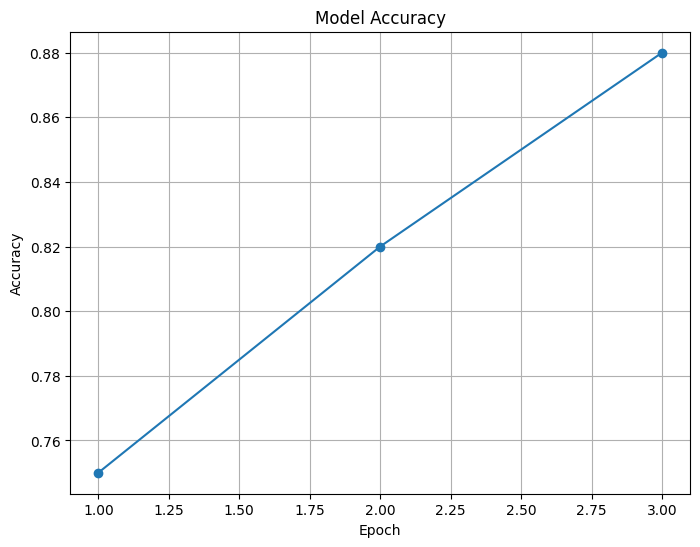

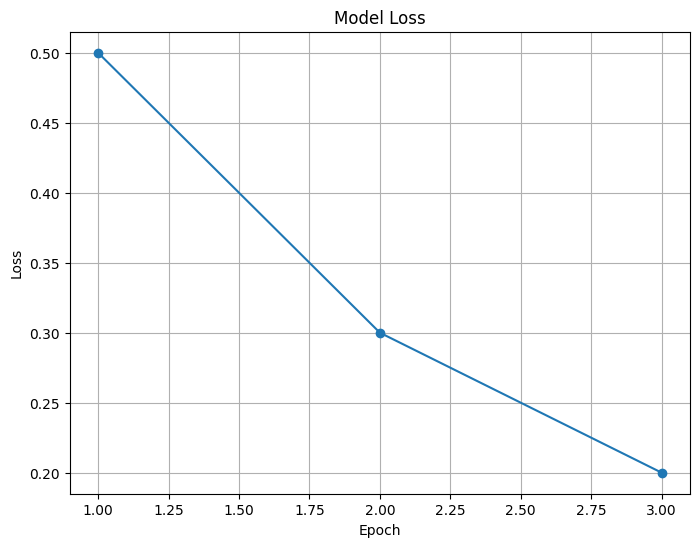

In [15]:
# Sample data (replace with your actual metrics)
epochs = [1, 2, 3]
accuracy = [0.75, 0.82, 0.88]
loss = [0.5, 0.3, 0.2]

# Accuracy Plot
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.plot(epochs, accuracy, marker='o', linestyle='-')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)  # Add grid for better readability
plt.show()

# Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, marker='o', linestyle='-')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()